In [1]:
%run cases.ipynb

naca1.dat failed. ERROR: float division by zero
Normal: 829544 831325 829544
Rennes: 31526 31527 27641
Experimental: 1012 2664 1012


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, optimizers
from keras.layers import Dense, BatchNormalization, Normalization, Activation, InputLayer, LeakyReLU, PReLU, Dropout
from keras.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.ensemble import AdaBoostRegressor
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

2023-05-06 19:29:35.849361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def get_data(df1, df2=None, nTrain=100, nTest=50, p_foil=None, p_Re=None):
    NNdata_df = df1.drop(columns = ['spline', 'xy_profile'])
               
    if df2 is not None:
        NNexp_df = df2.drop(columns = ['spline', 'xy_profile'])

        if p_foil:
            test_df = NNexp_df[NNexp_df.file == p_foil]
        else:
            test_df = NNexp_df
        
        if p_Re:
            test_df = test_df[test_df.Re == p_Re]

        t_indx = [random.randint(0, len(set(NNdata_df.file))-1) for i in range(nTrain)]
        t_foils = [list(set(NNdata_df.file))[indx] for indx in t_indx]
        if p_foil:
            t_foils = [i for i in t_foils if aerofoil_difference(df=df1, name1=i, name2=p_foil) > 0.5]

        train_df = shuffle(NNdata_df[NNdata_df.file.str.contains("|".join(t_foils))])
        if p_foil:
            train_df = train_df[train_df.file != p_foil]
        if p_Re:
            train_df = train_df[train_df.Re != p_Re]

        train_df['weights'] = [1]*len(train_df)

        if p_foil:
            Texp_df = NNexp_df[NNexp_df.file != p_foil]
        else:
            Texp_df = NNexp_df
        
        if p_Re:
            Texp_df = Texp_df[Texp_df.Re != p_Re]

        Texp_df['weights'] = [5]*len(Texp_df)
        Texp_df.loc[Texp_df.alpha > 10, 'weights'] = 10
        Texp_df.loc[Texp_df.alpha < -10, 'weights'] = 10

        train_df = train_df[~train_df.file.str.contains("|".join(list(set(Texp_df.file))))]

        train_df = shuffle(pd.concat([train_df, Texp_df]))
        
        print(f' N. Xfoil Training Aerofoils: {len(set(train_df.file.tolist()))}')
        print(f' N. Xfoil in Training: {len(train_df)}')
        print(f' N. Exp. Training Aerofoils: {len(set(Texp_df.file.tolist()))}')
        print(f' N. Experimental in Training: {len(Texp_df)}')
        
    else:
        if p_foil:
            test_df = NNdata_df[NNdata_df.file == p_foil]
            if p_Re:
                test_df = test_df[test_df.Re == p_Re]

            t_indx = [random.randint(0, len(set(NNdata_df.file))-1) for i in range(nTrain)]
            t_foils = [list(set(NNdata_df.file))[indx] for indx in t_indx]
            t_foils = [i for i in t_foils if aerofoil_difference(df=df1, name1=i, name2=p_foil) > 0.5]

            train_df = shuffle(NNdata_df[NNdata_df.file.str.contains("|".join(t_foils))])
            train_df = train_df[train_df.file != p_foil]
            if p_Re:
                train_df = train_df[train_df.Re != p_Re]
            
            print(f' N. Xfoil Training Aerofoils: {len(t_foils)}')
            print(f' N. Xfoil in Training: {len(train_df)}')
        
        else:
            p_indx = [random.randint(0, len(set(NNdata_df.file))-1) for i in range(nTest)]
            p_foils = [list(set(NNdata_df.file))[indx] for indx in p_indx]

            test_df = NNdata_df[NNdata_df['file'].str.contains(f"|".join(p_foils))]
            if p_Re:
                test_df = test_df[test_df.Re == p_Re]

            t_indx = [random.randint(0, len(set(df1.file))-1) for i in range(nTrain)]
            t_foils = [list(set(df1.file))[indx] for indx in t_indx if indx not in p_indx]

            train_df = shuffle(NNdata_df[NNdata_df.file.str.contains("|".join(t_foils))])
            if p_Re:
                train_df = train_df[train_df.Re != p_Re]
            
            print(f' N. Xfoil Training Aerofoils: {len(t_foils)}')
            print(f' N. Xfoil in Training: {len(train_df)}')
            
        train_df['weights'] = [1]*len(train_df)
        train_df.loc[train_df.alpha > 10, 'weights'] = 2
        train_df.loc[train_df.alpha < -10, 'weights'] = 2
    
    sample_weights = np.array(train_df.weights.tolist())

    return train_df, test_df, sample_weights


def prep_data(data):
    train_in = np.array([[0.0 if math.isnan(y) else y for y in ys_up] +
                         [0.0 if math.isnan(y) else y for y in ys_low] +
                         [float(Re)] + [float(alpha)] for ys_up, ys_low, Re, alpha in 
                         zip(data[0].y_up.tolist(), data[0].y_low.tolist(), data[0].Re.tolist(), data[0].alpha.tolist())], 
                        dtype='float32')

    train_out = np.array([[float(cl), float(cd)] for cl, cd in zip(data[0].Cl.tolist(), data[0].Cd.tolist())], 
                         dtype='float32')

    test_in = np.array([[0.0 if math.isnan(y) else y for y in ys_up] +
                        [0.0 if math.isnan(y) else y for y in ys_low] +
                        [float(Re)] + [float(alpha)] for ys_up, ys_low, Re, alpha in 
                        zip(data[1].y_up.tolist(), data[1].y_low.tolist(), data[1].Re.tolist(), data[1].alpha.tolist())], 
                       dtype='float32')

    test_out = np.array([[float(cl), float(cd)] for cl, cd in zip(data[1].Cl.tolist(), data[1].Cd.tolist())], 
                        dtype='float32')

    return train_in, train_out, test_in, test_out

In [4]:
def accuracy(y_true, y_pred):
    indx = 0
    for t, p in zip(y_true, y_pred):
        if np.abs(t - p) < 0.01:
            indx+=1
        else:
            pass
    score = indx / len(y_pred)
    return score

In [5]:
train_df, test_df, sample_weights = get_data(df1=data_df, df2=exp_data_df, nTrain=250, nTest=50, p_foil='n0012', p_Re=1000000)
train_in, train_out, test_in, test_out = prep_data(data=[train_df, test_df])
dat = [train_in, train_out, test_in, test_out]

print(len(train_df), len(test_df))

 N. Xfoil Training Aerofoils: 276
 N. Xfoil in Training: 140174
 N. Exp. Training Aerofoils: 4
 N. Experimental in Training: 1012
140174 1012


In [6]:
# ren_train_df, ren_test_df = get_data(df1=ren_data_df, df2=exp_data_df, nTrain=250, nTest=50)#, p_foil='n0012', p_Re=1000000)
# ren_train_in, ren_train_out, ren_test_in, ren_test_out = prep_data(data=[ren_train_df, ren_test_df])
# ren_dat = [ren_train_in, ren_train_out, ren_test_in, ren_test_out]

# print(len(ren_train_df), len(ren_test_df))

In [7]:
class Model:

    def __init__(self, data, neurons, activation, weights, name, test_df, EPOCHS=50, BATCH=256, lr=0.001, verbose=0, callbacks=None):
        self.train_in = data[0]
        self.train_out = data[1]
        self.test_in = data[2]
        self.test_out = data[3]
        self.neurons = neurons
        self.activation = activation
        self.weights = weights
        self.name = name
        self.test_df = test_df
        self.lr = lr
        self.EPOCHS = EPOCHS
        self.BATCH = BATCH
        self.verbose = verbose
        self.callbacks = callbacks
        
        self.model = None
        self.fitHistory = None
        self.trainEv = None
        self.testEv = None
        self.pred = None
        self.Pmetrics_df = None
        self.output_df = None
        
        self.model = self.build_MLP()
        self.fitHistory = self.train()
        self.trainEv, self.testEv = self.evaluate()
        self.pred, self.Pmetrics_df, self.output_df = self.predict()
        
    
    def build_MLP(self):
        model = Sequential(name=self.name)
        
        model.add(InputLayer(input_shape=len(self.train_in[0])))
        model.add(BatchNormalization())

        for n in self.neurons[1]:
            model.add(Dense(self.neurons[0][n]))

            if self.activation == 'leakyrelu':
                model.add(LeakyReLU(alpha=0.3))
            elif self.activation == 'prelu':
                model.add(PReLU(alpha_initializer='zeros'))
            else:
                model.add(Activation(self.activation))
            
            model.add(BatchNormalization())
            #model.add(Dropout(0.1))

        model.add(Dense(len(self.test_out[0])))

        OPT = optimizers.Adam(learning_rate=self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
        METS = ['ACC', 'MAE', 'MSE']
        model.compile(optimizer=OPT, loss='MSE', metrics=METS, weighted_metrics=METS)#, loss_weights=[1,2])

        if self.verbose == 1:
            print(model.summary())
        
        return model
    
    
    def train(self):
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=self.verbose, mode='min')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, verbose=self.verbose, 
                                      min_delta=1e-4, mode='min')
        if self.callbacks:
            self.callbacks = [reduce_lr] #, early_stop]

        fitHistory = self.model.fit(self.train_in, self.train_out, epochs=self.EPOCHS, batch_size=self.BATCH, 
                                    validation_split=0.1, verbose=self.verbose, callbacks=self.callbacks, 
                                    sample_weight=self.weights) #, class_weight={0:1, 1:1.5})
        
        return fitHistory
    
    
    def evaluate(self):
        trainEv = self.model.evaluate(self.train_in, self.train_out, batch_size=self.BATCH)
        testEv = self.model.evaluate(self.test_in, self.test_out, batch_size=self.BATCH)

        return trainEv, testEv
    
    
    def predict(self, test_in=None, test_out=None, test_df=None):
        if test_in is None:
            test_in = self.test_in
            test_out = self.test_out
            test_df = self.test_df
        
        pred = self.model.predict(test_in)
    
        clp = [p[0] for p in pred]
        cdp = [p[1] for p in pred]
        ldp = [l/d for l,d in zip(clp,cdp)]
        clt = [t[0] for t in test_out]
        cdt = [t[1] for t in test_out]
        ldt = [l/d for l,d in zip(clt,cdt)]
        p = clp + cdp
        t = clt + cdt

        ACC_cl = accuracy(clt, clp)
        ACC_cd = accuracy(cdt, cdp)
        ACC = accuracy(t, p)
        R2_cl = r2_score(clt, clp)
        R2_cd = r2_score(cdt, cdp)
        MSE_cl = mean_squared_error(clt, clp)
        MSE_cd = mean_squared_error(cdt, cdp)
        MSE = mean_squared_error(t, p)
        MAE_cl = mean_absolute_error(clt, clp)
        MAE_cd = mean_absolute_error(cdt, cdp)
        MAE = mean_absolute_error(t, p)
        RMSE_cl = math.sqrt(MSE_cl)
        RMSE_cd = math.sqrt(MSE_cd)
        RMSE = math.sqrt(MSE)
        Pmetrics_df = pd.DataFrame({'name': [str(self.name)], 
                                    'ACC_cl': [float(ACC_cl)], 'ACC_cd': [float(ACC_cd)], 'ACC': [float(ACC)],
                                    'MAE_cl': [float(MAE_cl)], 'MAE_cd': [float(MAE_cd)], 'MAE': [float(MAE)], 
                                    'R2_cl': [float(R2_cl)], 'R2_cd': [float(R2_cd)], 
                                    'MSE_cl': [float(MSE_cl)], 'MSE_cd': [float(MSE_cd)], 'MSE': [float(MSE)], 
                                    'RMSE_cl': [float(RMSE_cl)], 'RMSE_cd': [float(RMSE_cd)], 'RMSE': [float(RMSE)]})
        
        output_df = test_df.copy()
        output_df = output_df.drop(columns=['x', 'y_up', 'y_low'])
        output_df['LtD'] = ldt
        output_df['Cl_pred'] = clp
        output_df['Cd_pred'] = cdp
        output_df['LtD_pred'] = ldp

        return pred, Pmetrics_df, output_df

In [8]:
def run_Model(data, neurons, activation, weights, test_df, EPOCHS=50, BATCH=256, lr=0.1, verbose=0, callbacks=None):
    models = {}
    for act in activation:
        name = f'MLP-{act.capitalize()}'
        print(f'  ====  {name}  ====')
        model = Model(data=data, 
                      neurons=neurons, 
                      activation=act, 
                      weights=weights,
                      name=name, 
                      test_df=test_df,
                      EPOCHS=EPOCHS, 
                      BATCH=BATCH, 
                      lr=lr,
                      verbose=verbose,
                      callbacks=callbacks)

        models[name] = model
    return models
    

def model_predict(model, test_in, test_out, test_df):
    pred, Pmetrics_df, output_df = model.predict(test_in, test_out, test_df)
    
    return pred, Pmetrics_df, output_df

In [9]:
neurons = [[512, 256, 128, 64, 32, 16], [1,2,3,4]]
activations = ['sigmoid'] #, 'hard_sigmoid', 'softmax', 'softsign', 'leakyrelu', 'selu', 'elu', 'prelu', 'tanh']
activationz = ['swish', 'softplus', 'relu', 'gelu']

models = run_Model(data=dat, 
                   neurons=neurons, 
                   activation=activations, 
                   weights=sample_weights,
                   test_df=test_df, 
                   EPOCHS=100, 
                   BATCH=256, 
                   lr=0.001, 
                   verbose=0,
                   callbacks=True)

  ====  MLP-Sigmoid  ====
32/32 [==============================] - 0s 2ms/step


In [10]:
model = list(models.values())[0]

In [11]:
pred, Pmetrics_df, output_df = model.pred, model.Pmetrics_df, model.output_df

In [12]:
pred, Pmetrics_df, output_df = model_predict(model=model, test_in=test_in, test_out=test_out, test_df=test_df)
#pred, Pmetrics_df, output_df = model_predict(model=model, test_in=ren_test_in, test_out=ren_test_out, test_df=ren_test_df)

32/32 [==============================] - 0s 3ms/step


In [13]:
def pred_metrics(Pmetrics_df, models, file='results/metrics/prediction-mets.csv', df_from='current', add=False, 
                 df_save=False, prnt=False, plot=False):
    if df_from == 'current':
        metrics_df = Pmetrics_df
        metrics_df['DateTime'] = [str(datetime.now())] * len(metrics_df)
    
    elif df_from == 'models':
        metrics_df = pd.DataFrame()
        for name, model in models.items():
            new_row = model.Pmetrics_df
            metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
        metrics_df['DateTime'] = [str(datetime.now())] * len(metrics_df)
            
    elif df_from == 'file':
        metrics_df = pd.read_csv(file, index_col=0)
        
        if add == 'current':
            new_row = Pmetrics_df
            new_row['DateTime'] = [str(datetime.now())] * len(new_row)
            metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        elif add == 'models':
            for name, model in models.items():
                new_row = model.Pmetrics_df
                new_row['DateTime'] = [str(datetime.now())] * len(new_row)
                metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
    
    if df_save:
        metrics_df.to_csv(file)
        
    if prnt:
        print('=== PREDICTION METRICS ===')
        for index, row in metrics_df.iterrows():
            print(f' MODEL: {row[0]}.')
            print(f'   ACC:  CL: {round(row[1], 6)} and CD: {round(row[2], 6)} and ALL: {round(row[3], 6)}.')
            print(f'   MAE:  CL: {round(row[4], 6)} and CD: {round(row[5], 6)} and ALL: {round(row[6], 6)}.')
            print(f'    R2:  CL: {round(row[7], 6)} and CD: {round(row[8], 6)}.')
            print(f'   MSE:  CL: {round(row[9], 6)} and CD: {round(row[10], 6)} and ALL: {round(row[11], 6)}.')
            print(f'  RMSE:  CL: {round(row[12], 6)} and CD: {round(row[13], 6)} and ALL: {round(row[14], 6)}.', '\n')
        
    if plot:
        names = list(metrics_df.name)
        cols = ['blue', 'orangered', 'green']
        
        fig = plt.figure(0)
        fig.suptitle('PREDICTION METRICS', fontsize=16, fontname="Times New Roman", fontweight='bold')
        fig.set_figheight(10)
        fig.set_figwidth(20)
        axs = fig.subplots(2,2)
        
        rels = [[list(metrics_df.ACC_cl), list(metrics_df.ACC_cd), list(metrics_df.ACC)],
                [list(metrics_df.MAE_cl), list(metrics_df.MAE_cd), list(metrics_df.MAE)],
                [list(metrics_df.MSE_cl), list(metrics_df.MSE_cd), list(metrics_df.MSE)],
                [list(metrics_df.RMSE_cl), list(metrics_df.RMSE_cd), list(metrics_df.RMSE)]]
        titles = ['Accuracy', 'Mean Average Error', 'Mean Squared Error', 'Root Mean Squared Error']
        labelss = [['ACC_cl', 'ACC_cd', 'ACC'], ['MAE_cl', 'MAE_cd', 'MAE'],
                  ['MSE_cl', 'MSE_cd', 'MSE'], ['RMSE_cl', 'RMSE_cd', 'RMSE']]
        axindxs = [[0, 0, 1, 1], [0, 1, 0, 1]]
        
        for rel, title, labels, i, j in zip(rels, titles, labelss, axindxs[0], axindxs[1]):
            axs[i,j].set_title(title, fontsize=15, fontname="Times New Roman", fontweight='bold')
            axs[i,j].set_ylabel(title, fontsize=12, fontname="Times New Roman")
            x = np.arange(len(names))
            w = 0.2
            m = 0
            for lst, col, label in zip(rel, cols, labels):
                offset = w * m
                bars = axs[i,j].bar(x+offset, lst, color=col, width=w/1.5, label=label)
                axs[i,j].bar_label(bars, padding=0, fontsize=11, fontname="Times New Roman")
                m += 1
            axs[i,j].set_ylim(0,max(rel[0]+rel[1]+rel[2])*1.25)
            axs[i,j].legend()
            axs[i,j].set_xticks(x+w)
            axs[i,j].set_xticklabels(names, rotation=0) 
        
    return metrics_df
    

def train_metrics(model, models, mets=['loss', 'ACC', 'MAE'], df_from='current', prnt=False, plot=False):
    if df_from == 'current':
        models = {model.name: model}
        fitHistory = model.fitHistory

    elif df_from == 'models':
        models = models
        fitHistory = [model.fitHistory for model in list(models.values())]
    
    if prnt:
        print('=== TRAIN, VAL & EVAL METRICS ===')
        for name, model in models.items():
            print(f'MODEL : {name}')
            train_loss = list(model.fitHistory.history.get(f'{mets[0]}'))[-1]
            val_loss = list(model.fitHistory.history.get(f'val_{mets[0]}'))[-1]
            print(f'{mets[0].upper()} : Training: {round(train_loss, 6)}, Validation: {round(val_loss, 6)}.')
            train_acc = list(model.fitHistory.history.get(f'{mets[1]}'))[-1]
            val_acc = list(model.fitHistory.history.get(f'val_{mets[1]}'))[-1]
            print(f'{mets[1].upper()} : Training: {round(train_acc, 4)}, Validation: {round(val_acc, 4)}.')
            if len(mets) == 3:
                train_mae = list(model.fitHistory.history.get(f'{mets[2]}'))[-1]
                val_mae = list(model.fitHistory.history.get(f'val_{mets[2]}'))[-1]
                print(f'{mets[2].upper()} : Training: {round(train_mae, 4)}, Validation: {round(val_mae, 4)}.')
            print(f'EVALUATE \n Train: {model.trainEv}, \n Test: {model.testEv}.', '\n')
    
    if plot:
        fig = plt.figure(1)
        fig.suptitle('TRAINING & VALIDATION METRICS', fontsize=20, fontname="Times New Roman", fontweight='bold')
        fig.set_figheight(6)
        fig.set_figwidth(20)
        if len(mets) == 2:
            ax1, ax2 = fig.subplots(1,2)
        elif len(mets) == 3:
            ax1, ax2, ax3 = fig.subplots(1,3)
        fig.tight_layout(pad=2, h_pad=2.5, w_pad=5)
        
        ax1.set_title('Loss (MSE) v. Epochs', fontsize=20, fontname="Times New Roman", fontweight='bold')
        ax1.set_ylabel('MSE', fontsize=18, fontname="Times New Roman")
        ax1.set_xlabel('Epoch', fontsize=18, fontname="Times New Roman")
        ax1.set_yscale('log')
        for name, model in models.items():
            ax1.plot(model.fitHistory.history.get(f'{mets[0]}'), label=f'Training {mets[0].upper()} {name}')
            ax1.plot(model.fitHistory.history.get(f'val_{mets[0]}'), label=f'Validation {mets[0].upper()} {name}')                    
        ax1.legend()
        
        ax2.set_title('Accuracy v. Epochs', fontsize=20, fontname="Times New Roman", fontweight='bold')
        ax2.set_ylabel('Accuracy', fontsize=18, fontname="Times New Roman")
        ax2.set_xlabel('Epoch', fontsize=18, fontname="Times New Roman")
        for name, model in models.items():
            ax2.plot(model.fitHistory.history.get(f'{mets[1]}'), label=f'Training {mets[1].upper()} {name}')
            ax2.plot(model.fitHistory.history.get(f'val_{mets[1]}'), label=f'Validation {mets[1].upper()} {name}')
        ax2.legend()
        
        if len(mets) == 3:
            ax3.set_title('MAE v. Epochs', fontsize=20, fontname="Times New Roman", fontweight='bold')
            ax3.set_ylabel('MAE', fontsize=18, fontname="Times New Roman")
            ax3.set_xlabel('Epoch', fontsize=18, fontname="Times New Roman")
            ax3.set_yscale('log')
            for name, model in models.items():
                ax3.plot(model.fitHistory.history.get(f'{mets[2]}'), label=f'Training {mets[2].upper()} {name}')
                ax3.plot(model.fitHistory.history.get(f'val_{mets[2]}'), label=f'Validation {mets[2].upper()} {name}')
            ax3.legend()
        
    return fitHistory

=== PREDICTION METRICS ===
 MODEL: MLP-Sigmoid.
   ACC:  CL: 0.212451 and CD: 0.474308 and ALL: 0.343379.
   MAE:  CL: 0.058928 and CD: 0.016472 and ALL: 0.0377.
    R2:  CL: 0.976209 and CD: 0.970213.
   MSE:  CL: 0.011511 and CD: 0.000656 and ALL: 0.006083.
  RMSE:  CL: 0.10729 and CD: 0.025604 and ALL: 0.077996. 

=== TRAIN, VAL & EVAL METRICS ===
MODEL : MLP-Sigmoid
LOSS : Training: 0.003948, Validation: 0.005462.
ACC : Training: 0.9733, Validation: 0.9757.
EVALUATE 
 Train: [0.005055958405137062, 0.9755874872207642, 0.03289474546909332, 0.005055958405137062, 0.9755874872207642, 0.03289474546909332, 0.005055958405137062], 
 Test: [0.006083378568291664, 0.9397233128547668, 0.03770037740468979, 0.006083378568291664, 0.9397233128547668, 0.03770037740468979, 0.006083378568291664]. 



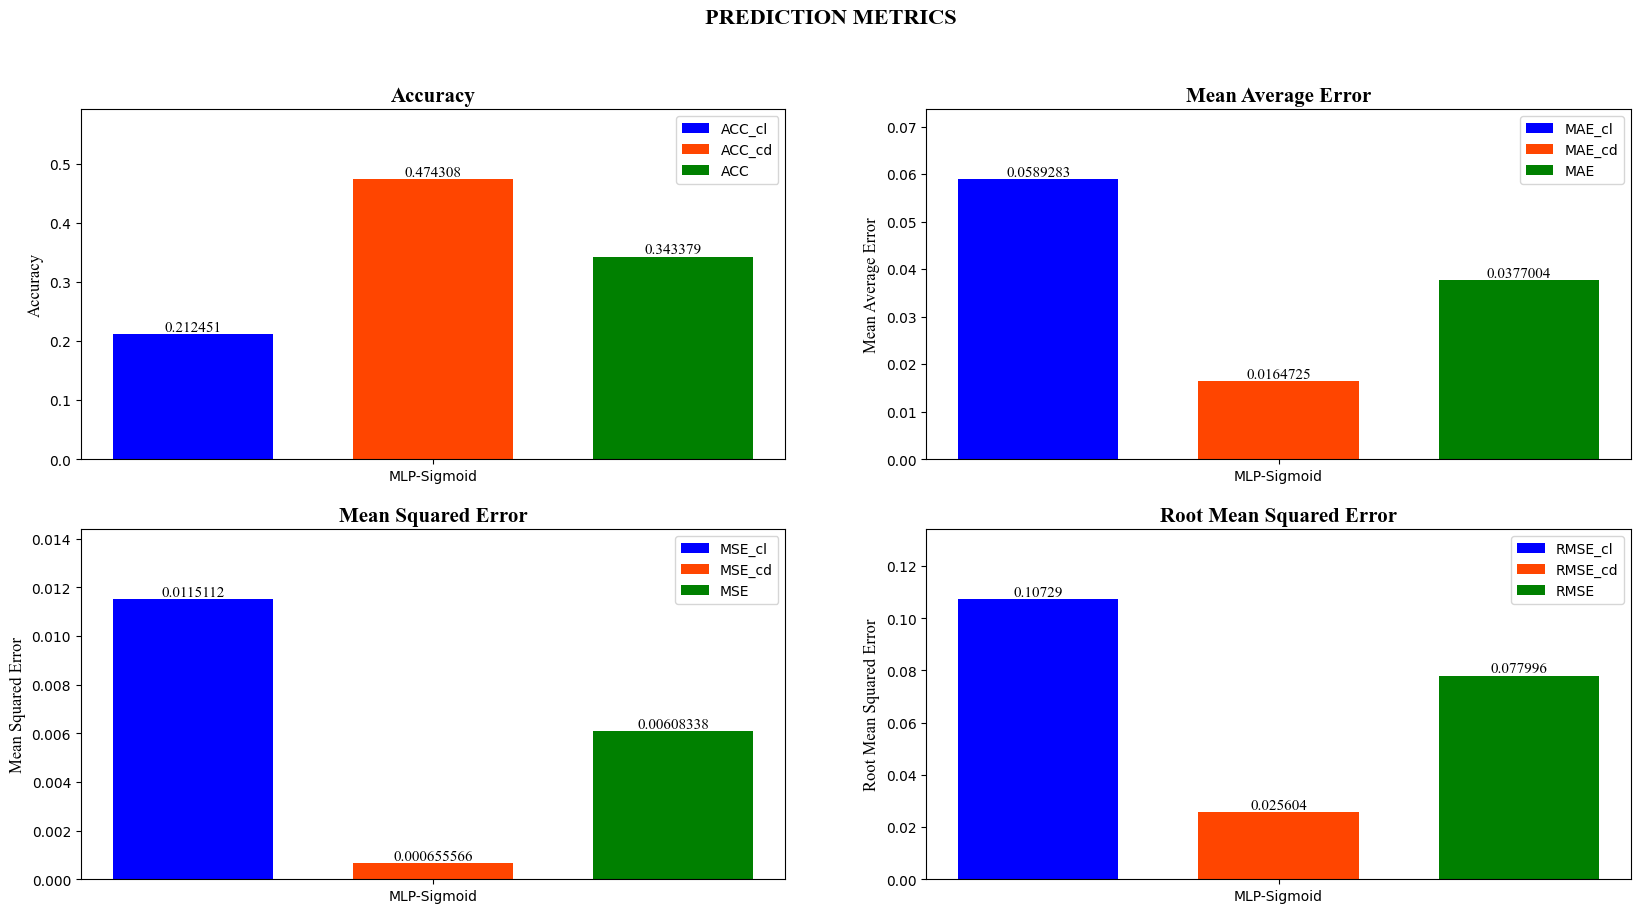

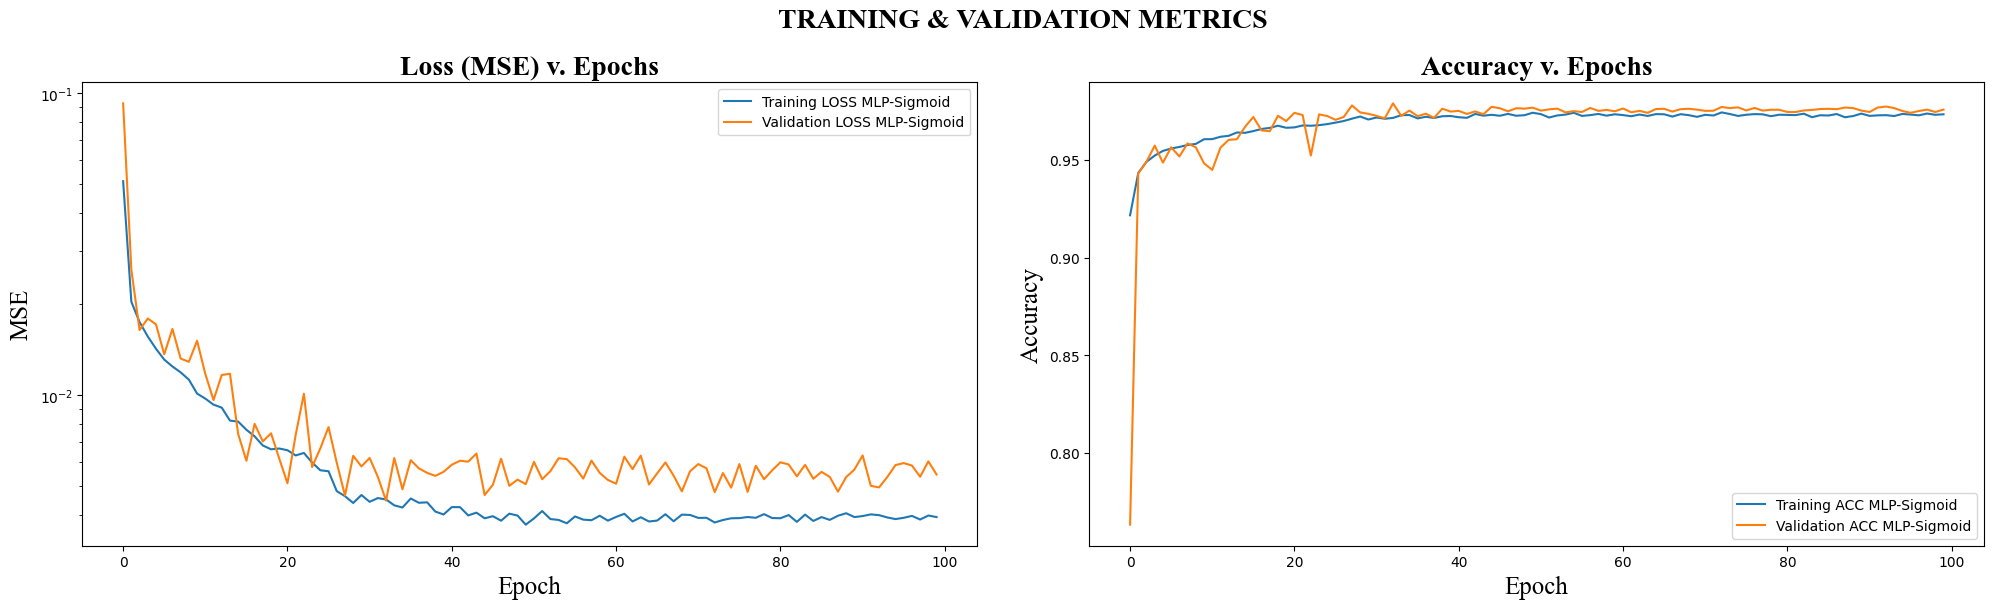

In [14]:
pred_metrics_df = pred_metrics(Pmetrics_df, 
                               models, 
                               file='results/metrics/prediction-metrics.csv', 
                               df_from='models', 
                               add=None, 
                               df_save=False, 
                               prnt=True, 
                               plot=True)

fitHistory = train_metrics(model=model,
                           models=models, 
                           mets=['loss', 'ACC'], 
                           df_from='models', 
                           prnt=True, 
                           plot=True)

In [15]:
def predictions(output=None, name=None, re=None, file='results/predictions.csv', df_from='current', aerofoils_df=aerofoils_df,
                model_add=False, df_save=False, plot=True, err=False):
    if df_from == 'current':
        df = output
            
    elif df_from == 'file':
        df = pd.read_csv(file, index_col=0)
        
    if model_add:
        new_row = output
        df = pd.concat([df, new_row], ignore_index=True)
    
    if df_save:
        df.to_csv(file)
    
    NAMEs = list(set(df.file.tolist()))
    REs = list(set(df.Re.tolist()))
    print([re for re in REs])
    print([name for name in NAMEs], '\n')

    plot_df = df[df.Re == re]
    plot_df = plot_df[plot_df.file == name]
    
    if plot:
        fig1 = plt.figure(2)
        fig1.set_figheight(10)
        fig1.set_figwidth(20)
        fig1.suptitle(plot_df.name.tolist()[0].upper()+' || Re = {:,}'.format(int(plot_df.Re.tolist()[0])),
                      fontsize=22, fontname="Times New Roman", fontweight='bold')
        axs = fig1.subplots(2,2)
        fig1.tight_layout(pad=2, h_pad=5, w_pad=8)

        axs[0,0].set_title('Lift Coefficient v. Angle of Attack', fontsize=20, fontname="Times New Roman", fontweight='bold')
        axs[0,0].set_xlabel('Angle of Attack [deg]', fontsize=18, fontname="Times New Roman")
        axs[0,0].set_ylabel('Lift Coefficient', fontsize=18, fontname="Times New Roman")
        a, t, p = plot_df.alpha.tolist(), plot_df.Cl.tolist(), plot_df.Cl_pred.tolist()
        axs[0,0].plot(a, p, '--', lw=1, marker='o', markersize=2, label='Predicted')
        axs[0,0].plot(a, t, lw=1, marker='o', markersize=2, label='True')
        axs[0,0].legend()#bbox_to_anchor=(0.15,1))
        
        if err:
            axs00 = axs[0,0].twinx()
            axs00.set_ylabel('Error', fontsize=18, fontname="Times New Roman", rotation=270, labelpad=15)
            err = [np.abs(tt - pp) for tt, pp in zip(t, p)]
            axs00.bar(a, err, width=(max(a)-min(a))/(2*len(a)), alpha=0.1, label='Error')
            axs00.set_ylim(0, 1.5*max(err))
            axs00.legend(bbox_to_anchor=(0.25,1))

        axs[0,1].set_title('Lift Coefficient v. Angle of Attack', fontsize=20, fontname="Times New Roman", fontweight='bold')
        axs[0,1].set_xlabel('Angle of Attack [deg]', fontsize=18, fontname="Times New Roman")
        axs[0,1].set_ylabel('Drag Coefficient', fontsize=18, fontname="Times New Roman")
        a, t, p = plot_df.alpha.tolist(), plot_df.Cd.tolist(), plot_df.Cd_pred.tolist()
        axs[0,1].plot(a, p, '--', lw=1, marker='o', markersize=2, label='Predicted')
        axs[0,1].plot(a, t, lw=1, marker='o', markersize=2, label='True')
        axs[0,1].legend()#bbox_to_anchor=(0.3,1))
        
        if err:
            axs01 = axs[0,1].twinx()
            axs01.set_ylabel('Error', fontsize=18, fontname="Times New Roman", rotation=270, labelpad=15)
            err = [np.abs(tt - pp) for tt, pp in zip(t, p)]
            axs01.bar(a, err, width=(max(a)-min(a))/(2*len(a)), alpha=0.1, label='Error')
            axs01.set_ylim(0, 1.5*max(err))
            axs01.legend(bbox_to_anchor=(0.4,1))
        
        axs[1,0].set_title('Lift to Drag Ratio v. Angle of Attack', fontsize=20, fontname="Times New Roman", fontweight='bold')
        axs[1,0].set_xlabel('Angle of Attack [deg]', fontsize=18, fontname="Times New Roman")
        axs[1,0].set_ylabel('Lift to Drag Ratio', fontsize=18, fontname="Times New Roman")
        a, t, p = plot_df.alpha.tolist(), plot_df.LtD.tolist(), plot_df.LtD_pred.tolist()
        axs[1,0].plot(a, p, '--', lw=1, marker='o', markersize=2, label='Predicted')
        axs[1,0].plot(a, t, lw=1, marker='o', markersize=2, label='True')
        axs[1,0].legend()#bbox_to_anchor=(0.15,1))
        
        if err:
            axs10 = axs[1,0].twinx()
            axs10.set_ylabel('Error', fontsize=18, fontname="Times New Roman", rotation=270, labelpad=15)
            err = [np.abs(tt - pp) for tt, pp in zip(t, p)]
            axs10.bar(a, err, width=(max(a)-min(a))/(2*len(a)), alpha=0.1, label='Error')
            axs10.set_ylim(0, 1.5*max(err))
            axs10.legend(bbox_to_anchor=(0.25,1))
        
        aindx = aerofoils_df.loc[aerofoils_df.file == name].index[0]
        plot_profile(aerofoils_df, aindx, scatt=False, x_val=False, ax=axs[1,1], prnt=False)
        
        plt.show()
    
    return plot_df

[160000.0, 20000.0, 40000.0, 80000.0, 360000.0, 700000.0, 1000000.0, 2000000.0, 5000000.0, 10000000.0, 3200000.0, 10000.0, 3000000.0]
['n0012', 's809', 'naca4412', 'naca0021'] 



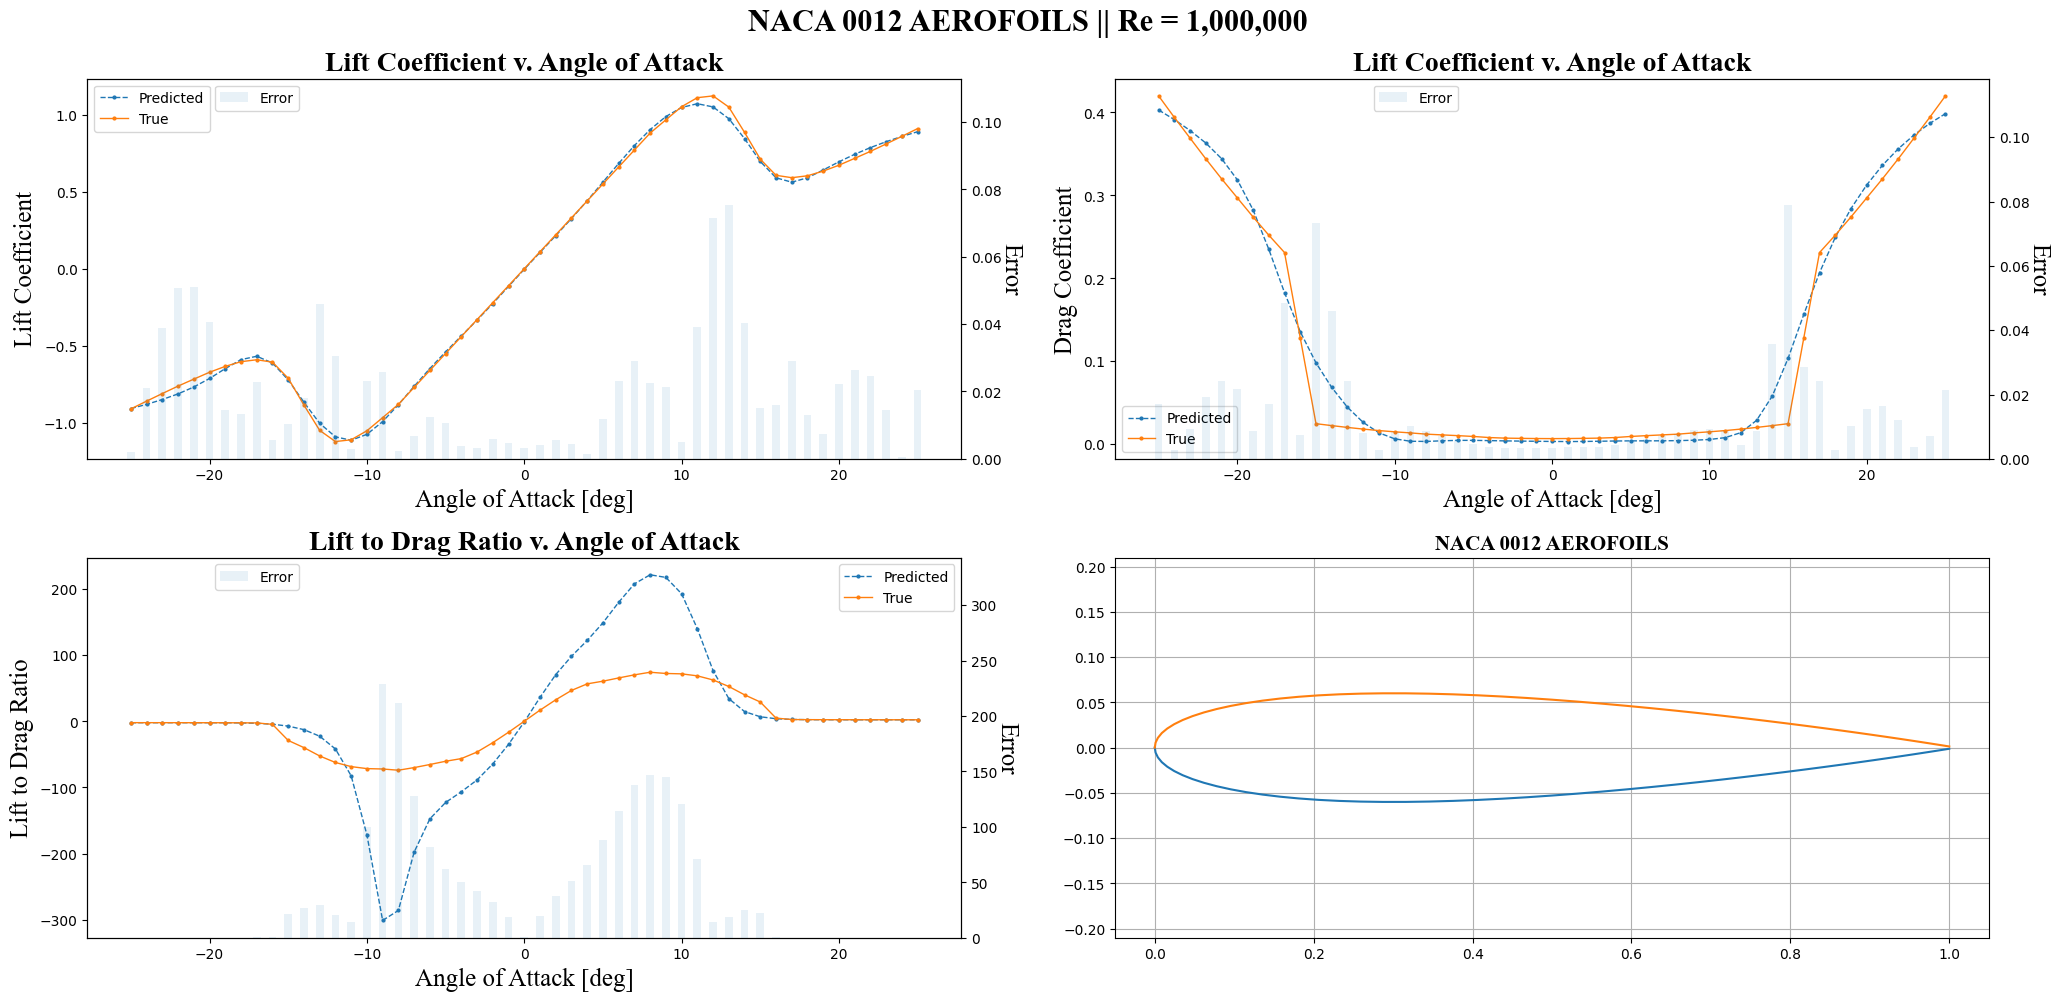

In [16]:
plot_df = predictions(output=output_df, 
                      name='n0012', 
                      re=1000000, 
                      file='results/predictions.csv', 
                      df_from='current', 
                      aerofoils_df=aerofoils_df, 
                      model_add=False, 
                      df_save=False, 
                      plot=True, 
                      err=True)